In [1]:
import pandas,json,numpy
import scipy,scipy.stats
import sklearn,sklearn.metrics,sklearn.metrics

import matplotlib,matplotlib.pyplot
matplotlib.rcParams.update({'font.size':40,'font.family':'Arial','xtick.labelsize':20,'ytick.labelsize':20,'axes.labelsize':33})
matplotlib.rcParams['pdf.fonttype']=42

In [2]:
def histogrammer(x):

    # get number of bins based on Rice's rule
    rice=int((len(x)**(1/3))*2)
    print('\t number of bins according to Rice: {}'.format(rice))

    counts,edges=numpy.histogram(x,bins=rice)
    half=(edges[1]-edges[0])/2
    centers=edges[:-1]+half

    return centers,counts

# 0. user defined variables

In [3]:
expression_file='/Volumes/GoogleDrive/My Drive/projects/MINER/data/MMRF_CoMMpass_IA13a_E74GTF/MMRF_CoMMpass_IA13a_E74GTF_Salmon_Gene_TPM.txt'
transcriptional_states_file='/Users/alomana/Google Drive File Stream/My Drive/projects/MINER/shared/MINER/results_minCorrelation_0o2_50_allFiles/transcriptional_states.json'

# 1. read data

## 1.1. read expression data

In [4]:
expression=pandas.read_csv(expression_file,header=0,index_col=0,sep="\t")
print(expression.shape)
expression.head()

(57997, 892)


,MMRF_1775_1_BM,MMRF_1407_1_BM,MMRF_1358_1_BM,MMRF_2813_1_BM,MMRF_2341_1_BM,MMRF_1380_2_BM,MMRF_2716_1_BM,MMRF_1710_1_BM,MMRF_1839_1_BM,MMRF_1755_1_BM,...,MMRF_2141_1_BM,MMRF_1941_1_BM,MMRF_1331_1_BM,MMRF_1327_1_BM,MMRF_1944_1_BM,MMRF_1915_1_BM,MMRF_2143_1_BM,MMRF_1683_1_BM,MMRF_1957_2_BM,MMRF_1773_1_BM
GENE_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,1.241630,1.83582,0.425776,4.987650,0.261943,6.68659,0.807806,4.31860,0.747555,0.375819,...,0.531679,1.206830,1.555390,0.736861,0.023523,0.015962,3.732960,3.60618,0.039907,0.036809
ENSG00000000005,0.008621,0.03133,0.000000,0.000000,0.031981,0.00000,0.000000,0.00000,0.000000,0.011938,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062777,0.00000,0.000000,0.000000
ENSG00000000419,18.235300,16.67170,18.409500,17.192400,27.803200,24.99560,11.764300,20.03830,16.482000,42.492300,...,14.521200,12.468100,14.442600,25.120900,26.061200,36.432700,11.700700,15.07760,14.912000,50.370700
ENSG00000000457,1.368570,2.39387,0.857731,0.725198,4.810990,4.65214,1.406890,3.89088,3.530600,6.051540,...,2.911840,1.955650,2.589970,5.895050,2.274490,1.747270,1.257150,5.66744,1.058240,2.746610
ENSG00000000460,0.284560,2.20924,0.345042,0.254061,2.895470,1.52748,0.298312,2.96181,1.153110,2.243760,...,0.726033,0.435713,0.430427,3.994530,1.100370,1.355290,0.417126,2.05526,0.688754,1.633540


## 1.2. obtain model state labels

In [5]:
# read data
with open(transcriptional_states_file) as json_file:
    states = json.load(json_file)

In [6]:
# remove peripheral blood samples
bm_states={}
for state_ID in states:
    bm=[element for element in states[state_ID] if element.split('_')[-1] == 'BM']
    bm_states[state_ID]=bm

In [7]:
# get a list of BM patients
all_patients=[]
for state_ID in bm_states:
    for patient in bm_states[state_ID]:
        if patient not in all_patients:
            all_patients.append(patient)
print(len(all_patients))

821


In [8]:
# intersect with count headers
intersect=list(set(expression.columns) & set(all_patients))
print(len(intersect))

821


In [9]:
# define states
states={}
for state in bm_states:
    states[state]=[]
    for patient in bm_states[state]:
        if patient in intersect:
            states[state].append(patient)

In [10]:
# define sizes
sizes=[]
for state in bm_states:
    sizes.append(len(states[state]))
sizes.sort(reverse=True)

# 2. perform analysis

In [11]:
# work with states with at least 50 patients
selected_states={}
selected_patients=[]
for key in states:
    if len(states[key]) > 5:
        print(key,len(states[key]))
        selected_states[key]=[]
        for element in states[key]:
            selected_states[key].append(element)
            selected_patients.append(element)

20 41
21 13
22 13
23 29
1 96
0 104
3 92
2 30
5 20
4 31
7 36
6 6
9 6
8 17
11 54
10 10
13 18
12 23
15 43
14 22
17 30
16 62
18 19


## 2.0. manipulate expression

In [12]:
# get rid of not mapping patients
expression=expression[selected_patients]
print(expression.shape)
expression.head()

(57997, 815)


,MMRF_1936_1_BM,MMRF_1167_1_BM,MMRF_1450_1_BM,MMRF_1931_2_BM,MMRF_1519_1_BM,MMRF_1285_3_BM,MMRF_1639_3_BM,MMRF_1415_1_BM,MMRF_1377_1_BM,MMRF_1024_1_BM,...,MMRF_1550_1_BM,MMRF_2541_1_BM,MMRF_2377_1_BM,MMRF_2506_1_BM,MMRF_2613_1_BM,MMRF_2599_1_BM,MMRF_2419_1_BM,MMRF_1510_1_BM,MMRF_1293_4_BM,MMRF_2526_1_BM
GENE_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,1.01656,11.89960,0.067842,0.161721,0.537514,0.015685,0.723633,0.168342,0.04889,3.63970,...,0.574591,0.00000,0.033046,2.171740,0.947116,1.940150,0.018530,3.906600,3.54412,0.484853
ENSG00000000005,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
ENSG00000000419,46.32200,60.15980,21.741200,19.133500,23.204000,20.719500,16.634600,24.733900,27.46590,9.97969,...,19.857600,16.86490,19.481900,19.717000,14.572600,15.804000,15.177200,36.946000,51.27170,24.620400
ENSG00000000457,9.75331,7.49491,6.288850,3.810520,3.484790,5.036420,6.569700,5.999570,8.15799,2.35342,...,5.963780,4.55216,2.764610,3.703490,2.430450,1.373920,2.308160,4.940500,9.63206,2.441070
ENSG00000000460,13.41730,4.49603,4.962080,1.962910,2.132390,2.038110,3.361740,7.454880,4.29618,0.40080,...,1.771180,3.58542,0.846159,0.528318,0.831450,0.446703,0.524472,0.916608,2.62106,0.742841


In [13]:
# remove genes that do not reach 10 TPMs
expression=expression[(expression > 10).any(axis=1)]
print(expression.shape)
expression.head()

(15239, 815)


,MMRF_1936_1_BM,MMRF_1167_1_BM,MMRF_1450_1_BM,MMRF_1931_2_BM,MMRF_1519_1_BM,MMRF_1285_3_BM,MMRF_1639_3_BM,MMRF_1415_1_BM,MMRF_1377_1_BM,MMRF_1024_1_BM,...,MMRF_1550_1_BM,MMRF_2541_1_BM,MMRF_2377_1_BM,MMRF_2506_1_BM,MMRF_2613_1_BM,MMRF_2599_1_BM,MMRF_2419_1_BM,MMRF_1510_1_BM,MMRF_1293_4_BM,MMRF_2526_1_BM
GENE_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,1.01656,11.89960,0.067842,0.161721,0.537514,0.015685,0.723633,0.168342,0.048890,3.63970,...,0.574591,0.000000,0.033046,2.171740,0.947116,1.940150,0.018530,3.906600,3.544120,0.484853
ENSG00000000419,46.32200,60.15980,21.741200,19.133500,23.204000,20.719500,16.634600,24.733900,27.465900,9.97969,...,19.857600,16.864900,19.481900,19.717000,14.572600,15.804000,15.177200,36.946000,51.271700,24.620400
ENSG00000000457,9.75331,7.49491,6.288850,3.810520,3.484790,5.036420,6.569700,5.999570,8.157990,2.35342,...,5.963780,4.552160,2.764610,3.703490,2.430450,1.373920,2.308160,4.940500,9.632060,2.441070
ENSG00000000460,13.41730,4.49603,4.962080,1.962910,2.132390,2.038110,3.361740,7.454880,4.296180,0.40080,...,1.771180,3.585420,0.846159,0.528318,0.831450,0.446703,0.524472,0.916608,2.621060,0.742841
ENSG00000000938,2.60901,2.88258,0.463524,0.339877,0.499740,0.168405,0.435191,2.871250,0.654986,2.30220,...,0.041721,0.028238,0.052738,0.353295,1.841330,0.263505,0.162321,0.381742,0.142741,1.901240


In [14]:
# transform to ranks
ranks=expression.rank(ascending=False)
print(ranks.shape)
ranks.head()

(15239, 815)


,MMRF_1936_1_BM,MMRF_1167_1_BM,MMRF_1450_1_BM,MMRF_1931_2_BM,MMRF_1519_1_BM,MMRF_1285_3_BM,MMRF_1639_3_BM,MMRF_1415_1_BM,MMRF_1377_1_BM,MMRF_1024_1_BM,...,MMRF_1550_1_BM,MMRF_2541_1_BM,MMRF_2377_1_BM,MMRF_2506_1_BM,MMRF_2613_1_BM,MMRF_2599_1_BM,MMRF_2419_1_BM,MMRF_1510_1_BM,MMRF_1293_4_BM,MMRF_2526_1_BM
GENE_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,12300.0,7212.0,13920.0,13326.0,12313.0,14191.0,11689.0,13248.0,13601.0,6277.0,...,11765.0,14639.0,13292.0,10391.0,11392.0,9161.0,13981.0,9328.0,9715.0,11862.0
ENSG00000000419,2411.0,1816.0,3315.0,3280.0,2308.0,3395.0,3517.0,3150.0,3452.0,3331.0,...,3659.0,3767.0,2334.0,3364.0,3597.0,2345.0,3181.0,2230.0,1673.0,1830.0
ENSG00000000457,7953.0,8921.0,7683.0,9102.0,8604.0,8593.0,6989.0,8095.0,7791.0,7544.0,...,7798.0,8344.0,8579.0,9180.0,9504.0,10104.0,9545.0,8726.0,6638.0,8479.0
ENSG00000000460,6784.0,10386.0,8466.0,10756.0,10045.0,10686.0,9214.0,7311.0,9581.0,10990.0,...,10580.0,9086.0,10929.0,12042.0,11573.0,12005.0,11899.0,11659.0,10316.0,11287.0
ENSG00000000938,11234.0,11235.0,12524.0,12761.0,12392.0,13028.0,12119.0,10155.0,11874.0,7609.0,...,13242.0,13520.0,13055.0,12343.0,10165.0,12504.0,12823.0,12325.0,12915.0,9211.0


## 2.1. Spearman correlation

In [15]:
# sort labels in order. not important, just for aestetic purposes
state_labels=list(selected_states.keys())
state_labels=[int(label) for label in state_labels]
state_labels.sort()
state_labels=[str(label) for label in state_labels]
print(state_labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '20', '21', '22', '23']


In [16]:
# find the average ranking of each state
for state in state_labels:
    average_label='average_state_'+state
    ranks[average_label]=ranks[selected_states[state]].median(axis=1)
print(ranks.shape)
ranks.head()

(15239, 838)


,MMRF_1936_1_BM,MMRF_1167_1_BM,MMRF_1450_1_BM,MMRF_1931_2_BM,MMRF_1519_1_BM,MMRF_1285_3_BM,MMRF_1639_3_BM,MMRF_1415_1_BM,MMRF_1377_1_BM,MMRF_1024_1_BM,...,average_state_13,average_state_14,average_state_15,average_state_16,average_state_17,average_state_18,average_state_20,average_state_21,average_state_22,average_state_23
GENE_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,12300.0,7212.0,13920.0,13326.0,12313.0,14191.0,11689.0,13248.0,13601.0,6277.0,...,12028.0,13943.0,10604.0,12440.5,11409.0,11862.0,13248.0,13336.0,12503.0,12611.0
ENSG00000000419,2411.0,1816.0,3315.0,3280.0,2308.0,3395.0,3517.0,3150.0,3452.0,3331.0,...,2480.0,2749.5,2938.0,2812.5,2384.0,2522.0,2675.0,2060.0,2583.0,2030.0
ENSG00000000457,7953.0,8921.0,7683.0,9102.0,8604.0,8593.0,6989.0,8095.0,7791.0,7544.0,...,8791.0,8054.0,8169.0,8947.0,8942.0,9013.0,8095.0,9001.0,9299.0,8864.0
ENSG00000000460,6784.0,10386.0,8466.0,10756.0,10045.0,10686.0,9214.0,7311.0,9581.0,10990.0,...,10850.0,7986.0,10089.0,11250.5,11032.5,11287.0,10048.0,10489.0,11619.0,10229.0
ENSG00000000938,11234.0,11235.0,12524.0,12761.0,12392.0,13028.0,12119.0,10155.0,11874.0,7609.0,...,9674.0,10824.5,12379.0,12646.0,12795.5,12659.0,12221.0,11361.0,9108.0,11658.0


In [17]:
average_ranks=ranks.iloc[:,-len(state_labels):]
ranks.drop(columns=average_ranks.columns,inplace=True)

In [18]:
print(average_ranks.shape)
average_ranks.head()

(15239, 23)


,average_state_0,average_state_1,average_state_2,average_state_3,average_state_4,average_state_5,average_state_6,average_state_7,average_state_8,average_state_9,...,average_state_13,average_state_14,average_state_15,average_state_16,average_state_17,average_state_18,average_state_20,average_state_21,average_state_22,average_state_23
GENE_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,11607.0,12915.0,12736.50,12469.5,12524.0,11876.0,9367.0,11016.0,9218.0,13093.5,...,12028.0,13943.0,10604.0,12440.5,11409.0,11862.0,13248.0,13336.0,12503.0,12611.0
ENSG00000000419,2211.0,2664.5,2621.25,3023.5,3120.0,3199.5,3014.0,2906.5,2640.0,2145.5,...,2480.0,2749.5,2938.0,2812.5,2384.0,2522.0,2675.0,2060.0,2583.0,2030.0
ENSG00000000457,9867.0,9312.0,10192.50,9149.5,9100.0,9593.0,9732.0,7716.5,7406.0,7870.5,...,8791.0,8054.0,8169.0,8947.0,8942.0,9013.0,8095.0,9001.0,9299.0,8864.0
ENSG00000000460,11656.5,11239.0,11985.00,11543.0,11314.0,12132.0,11440.0,10166.5,9947.0,8290.5,...,10850.0,7986.0,10089.0,11250.5,11032.5,11287.0,10048.0,10489.0,11619.0,10229.0
ENSG00000000938,10506.0,12121.5,9848.00,12657.5,12671.0,10987.5,3592.0,12839.5,12215.0,11437.5,...,9674.0,10824.5,12379.0,12646.0,12795.5,12659.0,12221.0,11361.0,9108.0,11658.0


In [19]:
print(ranks.shape)
ranks.head()

(15239, 815)


,MMRF_1936_1_BM,MMRF_1167_1_BM,MMRF_1450_1_BM,MMRF_1931_2_BM,MMRF_1519_1_BM,MMRF_1285_3_BM,MMRF_1639_3_BM,MMRF_1415_1_BM,MMRF_1377_1_BM,MMRF_1024_1_BM,...,MMRF_1550_1_BM,MMRF_2541_1_BM,MMRF_2377_1_BM,MMRF_2506_1_BM,MMRF_2613_1_BM,MMRF_2599_1_BM,MMRF_2419_1_BM,MMRF_1510_1_BM,MMRF_1293_4_BM,MMRF_2526_1_BM
GENE_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,12300.0,7212.0,13920.0,13326.0,12313.0,14191.0,11689.0,13248.0,13601.0,6277.0,...,11765.0,14639.0,13292.0,10391.0,11392.0,9161.0,13981.0,9328.0,9715.0,11862.0
ENSG00000000419,2411.0,1816.0,3315.0,3280.0,2308.0,3395.0,3517.0,3150.0,3452.0,3331.0,...,3659.0,3767.0,2334.0,3364.0,3597.0,2345.0,3181.0,2230.0,1673.0,1830.0
ENSG00000000457,7953.0,8921.0,7683.0,9102.0,8604.0,8593.0,6989.0,8095.0,7791.0,7544.0,...,7798.0,8344.0,8579.0,9180.0,9504.0,10104.0,9545.0,8726.0,6638.0,8479.0
ENSG00000000460,6784.0,10386.0,8466.0,10756.0,10045.0,10686.0,9214.0,7311.0,9581.0,10990.0,...,10580.0,9086.0,10929.0,12042.0,11573.0,12005.0,11899.0,11659.0,10316.0,11287.0
ENSG00000000938,11234.0,11235.0,12524.0,12761.0,12392.0,13028.0,12119.0,10155.0,11874.0,7609.0,...,13242.0,13520.0,13055.0,12343.0,10165.0,12504.0,12823.0,12325.0,12915.0,9211.0


In [20]:
average_ranks.corr()

,average_state_0,average_state_1,average_state_2,average_state_3,average_state_4,average_state_5,average_state_6,average_state_7,average_state_8,average_state_9,...,average_state_13,average_state_14,average_state_15,average_state_16,average_state_17,average_state_18,average_state_20,average_state_21,average_state_22,average_state_23
average_state_0,1.000000,0.979867,0.980031,0.947581,0.936924,0.948442,0.931846,0.944003,0.940006,0.911848,...,0.955081,0.916879,0.946061,0.941446,0.948331,0.935187,0.936595,0.940386,0.939096,0.944147
average_state_1,0.979867,1.000000,0.986452,0.983585,0.976056,0.970799,0.927052,0.967729,0.972453,0.932337,...,0.956605,0.950475,0.972698,0.980226,0.967084,0.976350,0.974365,0.955297,0.956213,0.968641
average_state_2,0.980031,0.986452,1.000000,0.973796,0.964537,0.973631,0.937411,0.941512,0.946694,0.909381,...,0.948590,0.926136,0.948536,0.961640,0.948273,0.960240,0.954653,0.935355,0.962453,0.951701
average_state_3,0.947581,0.983585,0.973796,1.000000,0.993345,0.981864,0.924820,0.956544,0.961008,0.925308,...,0.952006,0.940452,0.960546,0.983953,0.962345,0.978875,0.972351,0.944415,0.964642,0.964040
average_state_4,0.936924,0.976056,0.964537,0.993345,1.000000,0.978683,0.925609,0.953455,0.960865,0.925357,...,0.948857,0.945514,0.960705,0.981034,0.957651,0.979390,0.974809,0.944138,0.964404,0.962561
average_state_5,0.948442,0.970799,0.973631,0.981864,0.978683,1.000000,0.956263,0.940033,0.944532,0.911471,...,0.964982,0.922440,0.949430,0.967455,0.954741,0.964620,0.959307,0.938311,0.978258,0.960590
average_state_6,0.931846,0.927052,0.937411,0.924820,0.925609,0.956263,1.000000,0.899308,0.904743,0.878241,...,0.962379,0.879307,0.917470,0.910231,0.918789,0.909528,0.908709,0.909525,0.961787,0.925822
average_state_7,0.944003,0.967729,0.941512,0.956544,0.953455,0.940033,0.899308,1.000000,0.970709,0.956624,...,0.941832,0.953953,0.964255,0.967719,0.986157,0.957062,0.968244,0.952627,0.933085,0.962613
average_state_8,0.940006,0.972453,0.946694,0.961008,0.960865,0.944532,0.904743,0.970709,1.000000,0.934572,...,0.938581,0.952134,0.977398,0.975120,0.961829,0.967116,0.977711,0.940844,0.939220,0.968564
average_state_9,0.911848,0.932337,0.909381,0.925308,0.925357,0.911471,0.878241,0.956624,0.934572,1.000000,...,0.910604,0.952330,0.929060,0.935294,0.951292,0.925718,0.950576,0.934452,0.916037,0.947824


In [21]:
#! predict labels of each patient
predicted_labels=[]
true_labels=[]
        
for label in state_labels:
    for patient in selected_states[label]:
        # append true label
        true_labels.append(label)
        
        # compute Spearman-rank correlation to each average
        subset=average_ranks.join(ranks[patient],how='left')
        state_label_best_correlation_average=subset.corr()[patient].sort_values(ascending=False).index[1].split('_')[-1]
        predicted_labels.append(state_label_best_correlation_average)

In [22]:
for label in state_labels:
    print('State: {}. Predicted: {}. True: {}.'.format(label,predicted_labels.count(label),true_labels.count(label)))

State: 0. Predicted: 92. True: 104.
State: 1. Predicted: 41. True: 96.
State: 2. Predicted: 33. True: 30.
State: 3. Predicted: 88. True: 92.
State: 4. Predicted: 30. True: 31.
State: 5. Predicted: 39. True: 20.
State: 6. Predicted: 10. True: 6.
State: 7. Predicted: 32. True: 36.
State: 8. Predicted: 35. True: 17.
State: 9. Predicted: 7. True: 6.
State: 10. Predicted: 14. True: 10.
State: 11. Predicted: 54. True: 54.
State: 12. Predicted: 29. True: 23.
State: 13. Predicted: 27. True: 18.
State: 14. Predicted: 22. True: 22.
State: 15. Predicted: 44. True: 43.
State: 16. Predicted: 63. True: 62.
State: 17. Predicted: 32. True: 30.
State: 18. Predicted: 18. True: 19.
State: 20. Predicted: 40. True: 41.
State: 21. Predicted: 15. True: 13.
State: 22. Predicted: 18. True: 13.
State: 23. Predicted: 32. True: 29.


In [36]:
# compare predicted vs true labels
cm=sklearn.metrics.confusion_matrix(true_labels,predicted_labels,labels=state_labels)
f1=sklearn.metrics.f1_score(true_labels,predicted_labels,labels=state_labels,average='weighted')
print(f1)

0.7705580637423353


In [24]:
#  then single patient, then all states

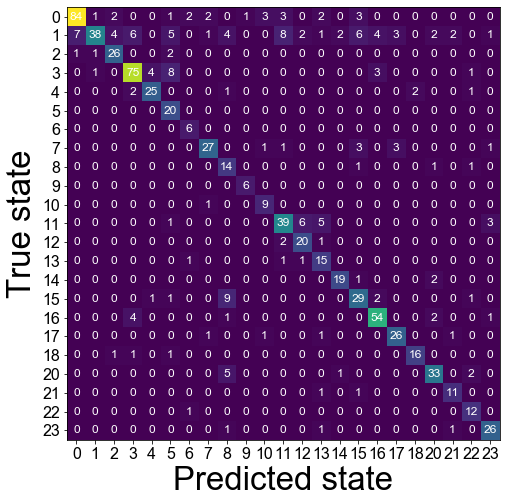

In [37]:
# plot results
matplotlib.pyplot.figure(None,(12,8))

matplotlib.pyplot.imshow(cm)

for i in range(len(state_labels)):
    for j in range(len(state_labels)):
        text = str(cm[j,i])
        matplotlib.pyplot.text(i,j,text,ha='center',va='center',color='w',fontsize=12)

matplotlib.pyplot.xlabel('Predicted state')
matplotlib.pyplot.ylabel('True state')
matplotlib.pyplot.xticks(numpy.arange(len(state_labels)),state_labels,fontsize=16)
matplotlib.pyplot.yticks(numpy.arange(len(state_labels)),state_labels,fontsize=16)
matplotlib.pyplot.tight_layout()

In [26]:
# find the average ranking per state, do a histogram per state
# find the intra/inter SRC 
# correlation to each patient, not average.


## 2.2. gene pairs

## 2.3. state descriptors

In [27]:
# values=df.iloc[:,:2].to_numpy()
# log2_values=numpy.log2(values+1)
# print(len(values))
# # centers,counts=histogrammer(log2_values)
# print(centers,counts)
# matplotlib.pyplot.plot(centers,counts,'o-',color='black')
# average=numpy.median(log2_values)
# deviation=numpy.std(log2_values)
# lb=average-deviation
# ub=average+deviation
# print(average,deviation)
# matplotlib.pyplot.axvline(average,color='red')
# matplotlib.pyplot.axvline(lb,color='orange')
# matplotlib.pyplot.axvline(ub,color='orange')
# matplotlib.pyplot.axvline(numpy.log10(1+1),color='blue')